<a href="https://colab.research.google.com/github/hyoutanisl/acnhdesignbackup/blob/master/ACNH_PlotDesign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
#-*- coding:utf-8 -*-
import cv2
import os
import shutil
from google.colab import files
import datetime

#一時ファイル削除
#!rm *.*

###########################################################
# マイデザイン入力パターンメーカー
# Author: ひょうたん島のこうじ  hyoutan_isl on twitter
###########################################################

#作業フォルダ
folderpath=datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
os.makedirs(folderpath, exist_ok=True)

uploadfiles = files.upload()
screenshotpath = list(uploadfiles.keys())[0]
orgpath=os.path.join(folderpath,screenshotpath)
shutil.copy(screenshotpath,folderpath)
print(os.listdir(folderpath))

bgrmd = cv2.imread(orgpath)
print("ImageSize {0}".format(bgrmd.shape))



Saving 2020052419381600-02CB906EA538A35643C1E1484C4B947D (1).jpg to 2020052419381600-02CB906EA538A35643C1E1484C4B947D (1) (1).jpg
['2020052419381600-02CB906EA538A35643C1E1484C4B947D (1).jpg']
ImageSize (720, 1280, 3)


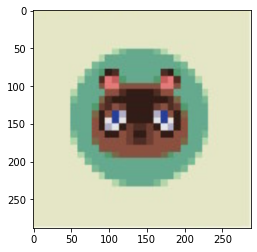

In [14]:
import numpy as np
import collections
import math
from matplotlib import pyplot as plt


#定数群
ICONSIZE=32
GAIN=9
WORKWIDTH=ICONSIZE*GAIN

#何色に減らすかを指定します。
#透明ピクセルを考慮して標準は15色で
NUMOFCOLOR=15


#他の人が作ったデザインのダウンロードプレビュー画面での座標
#イーゼルにのっている方ではなく、右側の正面図
AreaSize=152
xs=999
ys=330

#自分で作ったデザインののアップロード前
#xs=1000
#ys=363


height,width = bgrmd.shape[:2]
if((width==1280)&(height==720)):
  #通常はSwitchのスクリーンショットから切り出す
  designareaimg =bgrmd[ys:ys+AreaSize,xs:xs+AreaSize]
else:
  #それ以外は場合はそのまま全部使う
  designareaimg=bgrmd

#入力画像を作業画像サイズに変更
bgrwk=cv2.resize(designareaimg,(WORKWIDTH,WORKWIDTH),cv2.INTER_CUBIC)

#作業イメージ出力
rgbwk=cv2.cvtColor(bgrwk,cv2.COLOR_BGR2RGB)
plt.imshow(rgbwk)


4


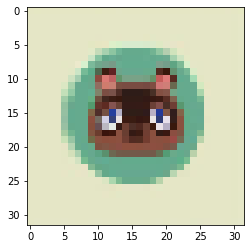

In [15]:
#大きいサイズの作業用イメージから
#マイデザインのサイズ(32x32)に変更
tmp=cv2.resize(bgrwk,(ICONSIZE,ICONSIZE))
bgr32=np.zeros_like(tmp)
offset=math.floor(GAIN/2)
print(offset)
for y in range(ICONSIZE):
  ny=y*GAIN+offset
  for x in range(ICONSIZE):
    nx=x*GAIN+offset
    bgr32[y][x]=bgrwk[ny][nx]

dargb=cv2.cvtColor(bgr32,cv2.COLOR_BGR2RGB)
plt.imshow(dargb)


In [16]:

#OpenCVとあつ森の色の段階の扱いは以下の通り
# H  0 to 179    1 to 30
# S  0 to 255    1 to 15
# V  0 to 255    1 to 15

def opencvhsv2acnhhsv(h,s,v):
    #OpenCvのHSVレベルをあつ森のHSVレベルに変換
    nh=math.floor(h/6)+1
    ns=math.floor(s/17)+1
    nv=math.floor(v/17)+1
    return nh,ns,nv

def shifthsv_for_acnh(h,s,v):
    # あつ森の色合い１は、Hの3ぐらいに相当。ほかも同じような感じ
    # H,S,Vをそれぞれ区間に区切り、区間のほぼ中央値になるよう補正
    nh= int(h/6)*6+3
    ns= int(s/17)*17+8
    nv= int(v/17)*17+8
    #s= "H {0} ->{1}   S {2}->{3}    V {4} ->{5}\n".format(h,nh,s,ns,v,nv)
    #print(s)
    return nh,ns,nv

def reduce_color(src, K):
#ref https://algorithm.joho.info/programming/python/opencv-kmeans-py/
    print(src.shape)
    Z = src.reshape((-1, 3))
    print(Z.shape)

    # float32型に変換
    Z = np.float32(Z)

    # 基準の定義
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0)

    # K-means法で減色
    ret, label, center = cv2.kmeans(
        Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # UINT8に変換
    center = np.uint8(center)
    for i in range(len(center)):
      h,s,v=shifthsv_for_acnh(center[i][0],center[i][1],center[i][2])
      center[i][0]=h
      center[i][1]=s
      center[i][2]=v
    
    res = center[label.flatten()]
    label = np.uint8(label)
    # 配列の次元数と入力画像と同じに戻す
    return res.reshape((src.shape)),label,center

#減色処理開始
hsv=cv2.cvtColor(bgr32,cv2.COLOR_BGR2HSV)
reducedhsv,labels,palettecolor=reduce_color(hsv,NUMOFCOLOR)

#パレットテーブルをテキストで出す
exportFile=os.path.join(folderpath,"DotPattern.txt")
with open(exportFile, mode='w') as f:

  f.write("=================================\n")
  f.write("マイデザイン入力パターンメーカー\n")
  f.write("=================================\n")
  f.write("元の画像："+screenshotpath+"\n")
  f.write("\n")
  f.write("パレットテーブル\n")
  f.write("=================\n")
  #print(palettecolor)
  f.write("No 色合い 鮮やかさ 明るさ\n")
  for i in range(len(palettecolor)):
    opencv_h=palettecolor[i][0]
    opencv_s=palettecolor[i][1]
    opencv_v=palettecolor[i][2]
    nh,ns,nv=opencvhsv2acnhhsv(opencv_h,opencv_s,opencv_v)
    
    paletteline= "{0}： {1} {2} {3} 　　　  HSV({4},{5},{6})\n".format(1+i,nh,ns,nv,opencv_h,int(opencv_s/2.56),int(opencv_v/2.56))
    f.write(paletteline)
  f.write("※HSVの値は開発用のものです。\n")
  f.write("\nドットデータ\n")
  f.write("====================\n")
  for i in range(len(labels)):
    v=int(labels[i])
    f.write("{:2}".format(v+1))
    if(i>1)&((i+1)%32==0):
      f.write("\n")
    elif((i%32)==15):
      f.write(", ")
    else:
      f.write(",")

dsbgr32=cv2.cvtColor(reducedhsv, cv2.COLOR_HSV2BGR)

#32x32では見ずらいので
#大きく拡大して保存
bigimage=np.zeros_like(bgrwk)
for y in range(WORKWIDTH):
  for x in range(WORKWIDTH):
    bigimage[y][x]=dsbgr32[math.floor(y/GAIN)][math.floor(x/GAIN)]
exportImage=os.path.join(folderpath,"result_big.bmp")
exportImage32=os.path.join(folderpath,"result_original.bmp")
cv2.imwrite(exportImage,bigimage)
cv2.imwrite(exportImage32,dsbgr32)

#donwload result
zippath=shutil.make_archive("Pattern", 'zip',folderpath)
files.download(zippath)
#files.download(exportImage)


(32, 32, 3)
(1024, 3)
